 🚲 NYC Bike Share Data Analysis
 
 ## 📋 Project Overview
 This notebook analyzes bike sharing data from New York City, providing insights into riding patterns, popular routes, and usage statistics.
 
 ## 🏗️ Architecture
 The project follows a medallion architecture for data processing:
 
 ### 🥉 Bronze Layer
 - Raw data ingestion
 - Data validation
 - Source tracking
 - Audit logging
 
 ### 🥈 Silver Layer
 - Data cleaning
 - Feature engineering
 - Quality checks
 - Enrichment with:
   - Ride duration
   - Distance calculations
   - Time-based features
 
 ### 🥇 Gold Layer
 - Analytics views
 - Aggregated metrics
 - Business KPIs
 - Reporting tables
 
 ## 🔧 Technical Setup
 This notebook leverages:
 - Apache Spark with Delta Lake
 - ELK Stack for logging
 - Docker containerization

In [1]:
# Import libraries
import os
import time
from datetime import datetime
import logging
import pandas as pd
import numpy as np
from pathlib import Path
import requests
import shutil
import zipfile
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import DataFrame
from pyspark.sql.types import *
from delta.tables import DeltaTable
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import seaborn as sns
from src.utils.notebook_logger import NotebookLogger
from typing import Optional
import sys

# Add notebooks directory to Python path
notebooks_dir = os.path.abspath("/home/aldamiz/notebooks")
if notebooks_dir not in sys.path:
    sys.path.append(notebooks_dir)
# Import local modules
from schema_manager import SchemaManager, DataFrameTransformer, DataValidator


# Initialize logger
logger = NotebookLogger('nycbs')
logger.info("Starting notebook execution")

# Initialize Spark with Delta configurations
start_time = time.time()
spark = SparkSession.builder.appName("NYCBS_Analysis").getOrCreate()
duration_ms = (time.time() - start_time) * 1000
logger.spark_operation(
    "Spark session initialized",
    operation_type="init",
    duration_ms=duration_ms,
    spark_version=spark.version
    ) 

# Define paths
WAREHOUSE_DIR = os.getenv('WAREHOUSE_DIR', '/home/aldamiz/warehouse')
DATA_DIR = os.getenv('DATA_DIR', '/home/aldamiz/data')
BRONZE_PATH = os.path.join(DATA_DIR, 'bronze')
SILVER_PATH = os.path.join(DATA_DIR, 'silver')
GOLD_PATH = os.path.join(DATA_DIR, 'gold')

# Display configuration summary
display(Markdown("""
### 🔍 Configuration Summary:
- 📂 Warehouse Directory: `{}`
- 📂 Data Directory: `{}`
- 🥉 Bronze Layer: `{}`
- 🥈 Silver Layer: `{}`
- 🥇 Gold Layer: `{}`
""".format(WAREHOUSE_DIR, DATA_DIR, BRONZE_PATH, SILVER_PATH, GOLD_PATH)))

2025-03-05 17:31:15,381 - INFO - [nycbs.notebook.nycbs] - Starting notebook execution
2025-03-05 17:31:22,702 - INFO - [nycbs.notebook.nycbs] - Spark session initialized



### 🔍 Configuration Summary:
- 📂 Warehouse Directory: `/home/aldamiz/warehouse`
- 📂 Data Directory: `/home/aldamiz/data`
- 🥉 Bronze Layer: `/home/aldamiz/data/bronze`
- 🥈 Silver Layer: `/home/aldamiz/data/silver`
- 🥇 Gold Layer: `/home/aldamiz/data/gold`


 # 📊 Control Table Setup
 
 ## Purpose
 The control table tracks the processing status of source files to ensure:
 - 🔄 Idempotency (no duplicate processing)
 - 📝 Audit trail of all operations
 - ⏱️ Processing timestamps
 - 📈 Record counts
 - 🎯 Status tracking
 
 ## Schema
 - `source_file`: Source file identifier
 - `file_path`: Location of processed data
 - `processing_date`: Timestamp of processing
 - `record_count`: Number of records processed
 - `status`: Processing status (SUCCESS/FAILED)
 - `year`, `month`: Temporal partitioning

In [2]:
# Initialize control table
control_table_path = os.path.join(WAREHOUSE_DIR, "control_table")

try:
    # Create control table if it doesn't exist
    if not DeltaTable.isDeltaTable(spark, control_table_path):
        logger.info("Creating control table")
        
        control_schema = StructType([
            StructField("source_file", StringType(), False),
            StructField("file_path", StringType(), False),
            StructField("processing_date", TimestampType(), False),
            StructField("record_count", LongType(), True),
            StructField("status", StringType(), False),
            StructField("year", IntegerType(), False),
            StructField("month", IntegerType(), False)
        ])
        
        # Create empty table with schema
        empty_df = spark.createDataFrame([], control_schema)
        empty_df.write.format("delta").mode("errorIfExists").save(control_table_path)
        
        display(HTML('<div style="color: #3c763d;">✅ Control table created</div>'))
    else:
        display(HTML('<div style="color: #31708f;">ℹ️ Control table exists</div>'))

    # Display schema and recent history
    control_df = spark.read.format("delta").load(control_table_path)
    
    # Show schema in a clean table
    schema_df = pd.DataFrame([
        {"Field": f.name, "Type": str(f.dataType), "Required": "Yes" if not f.nullable else "No"}
        for f in control_df.schema
    ])
    display(schema_df.style.set_properties(**{'padding': '5px'}))
    
    # Show recent processing history
    if control_df.count() > 0:
        display(control_df.orderBy(F.col("processing_date").desc())
               .limit(5).toPandas()
               .style.set_properties(**{'padding': '5px'}))

except Exception as e:
    logger.error(f"Error in control table setup: {str(e)}", error=e)
    display(HTML(f'<div style="color: #a94442;">❌ Error: {str(e)}</div>'))

,Field,Type,Required
0,source_file,StringType(),No
1,file_path,StringType(),No
2,processing_date,TimestampType(),No
3,record_count,LongType(),No
4,status,StringType(),No
5,year,IntegerType(),No
6,month,IntegerType(),No


/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:249: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,source_file,file_path,processing_date,record_count,status,year,month
0,202502-citibike-tripdata_3.csv,/home/aldamiz/data/bronze/rides_nyc,2025-03-05 17:23:47.858739,31257,SUCCESS,2025,2
1,202501-citibike-tripdata_1.csv,/home/aldamiz/data/bronze/rides_nyc,2025-03-05 17:23:41.426258,1000000,SUCCESS,2025,1
2,202501-citibike-tripdata_3.csv,/home/aldamiz/data/bronze/rides_nyc,2025-03-05 17:23:11.921694,124475,SUCCESS,2025,1
3,202502-citibike-tripdata_2.csv,/home/aldamiz/data/bronze/rides_nyc,2025-03-05 17:23:04.657765,1000000,SUCCESS,2025,2
4,202502-citibike-tripdata_1.csv,/home/aldamiz/data/bronze/rides_nyc,2025-03-05 17:22:34.699545,1000000,SUCCESS,2025,2


# 📥 Data Ingestion
 
 ## Landing Zone Structure
 - 📂 `landing/`: Storage for extracted CSV files
 - 📂 `landing/zip/`: Storage for downloaded ZIP files
 
 ## Configuration
 - 🌍 Source: NYC Citibike System Data
 - 📅 Select date range for data download
 - 🔄 Supports multiple years/months and cities
 - 📦 Automatic ZIP handling
 
 ## Process Flow
 1. 🎯 Define date range and cities
 2. 🌐 Download ZIP files to `landing/zip/`
 3. 📦 Extract CSV files to `landing/`
 4. ✅ Validate files
 
 ## File Patterns
 ### NYC Files
 - 2013-2023: `YYYY-citibike-tripdata.zip` (annual files)
 - 2024 (Jan-Apr): `YYYYMM-citibike-tripdata.csv.zip`
 - 2024 (May+): `YYYYMM-citibike-tripdata.zip`
 - 2025+: `YYYYMM-citibike-tripdata.zip`
 
 ### Jersey City (JC) Files
 - 2015+: `JC-YYYYMM-citibike-tripdata.csv.zip`

In [3]:
import sys
import os

# Add notebooks directory to Python path
notebooks_dir = "/home/aldamiz/notebooks"
if notebooks_dir not in sys.path:
    sys.path.append(notebooks_dir)

from schema_manager import SchemaManager, DataFrameTransformer, DataValidator
# Date Range and City Configuration
display(HTML("""
<h4>📅 Configure Data Download:</h4>
<p>Modify these parameters to select your date range and cities:</p>
"""))

# Define parameters
START_YEAR = 2025    # Modify this for different start year
START_MONTH = 1      # 1-12
END_YEAR = 2025      # Modify this for different end year
END_MONTH = 12       # 1-12
CITIES = ['NYC']  # NYC for New York City, JC for Jersey City

def get_file_url(filename):
    """Generate S3 URL for a given filename"""
    return f'https://s3.amazonaws.com/tripdata/{filename}'

def generate_filename(city, year, month, current_date):
    """
    Generate the correct filename based on city and date
    
    NYC Pattern:
    - 2013-2023: YYYY-citibike-tripdata.zip (annual files)
    - 2024 (01-04): YYYYMM-citibike-tripdata.csv.zip
    - 2024 (05+) and beyond: YYYYMM-citibike-tripdata.zip
    
    JC Pattern:
    - 2015+: JC-YYYYMM-citibike-tripdata.csv.zip
    """
    # Check if the date is current month or future
    if year > current_date.year or (year == current_date.year and month >= current_date.month):
        return None

    if city == 'NYC':
        if year < 2024:
            # Annual files for 2013-2023
            if month == 12:  # Only generate annual file in December
                return f"{year}-citibike-tripdata.zip"
        else:  # 2024 and beyond
            if year == 2024 and 1 <= month <= 4:
                # January to April 2024: YYYYMM-citibike-tripdata.csv.zip
                return f"{year}{month:02d}-citibike-tripdata.csv.zip"
            else:
                # May 2024 onwards and all months in 2025+: YYYYMM-citibike-tripdata.zip
                return f"{year}{month:02d}-citibike-tripdata.zip"
    
    elif city == 'JC' and year >= 2015:  # JC data starts from 2015
        return f"JC-{year}{month:02d}-citibike-tripdata.csv.zip"
    
    return None

# Display configuration
display(HTML(f"""
<div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px;">
    <p><b>📅 Selected Configuration:</b></p>
    <ul>
        <li>Start: {START_YEAR}-{START_MONTH:02d}</li>
        <li>End: {END_YEAR}-{END_MONTH:02d}</li>
        <li>Cities: {', '.join(CITIES)}</li>
    </ul>
</div>
"""))

try:
    # Get current date for validation
    current_date = datetime.now()
    
    # Validate configuration
    if not (1 <= START_MONTH <= 12 and 1 <= END_MONTH <= 12):
        raise ValueError("Months must be between 1 and 12")
    if START_YEAR > END_YEAR or (START_YEAR == END_YEAR and START_MONTH > END_MONTH):
        raise ValueError("Start date must be before end date")
    
    # Create directories if they don't exist
    landing_path = os.path.join(DATA_DIR, "landing")
    zip_storage_path = os.path.join(landing_path, "zip")  # ZIP files storage
    control_table_path = os.path.join(WAREHOUSE_DIR, "control_table")
    Path(landing_path).mkdir(parents=True, exist_ok=True)
    Path(zip_storage_path).mkdir(parents=True, exist_ok=True)
    
    print(control_table_path)
    
    # Read control table
    control_df = spark.read.format("delta") \
            .option("mergeSchema", "true") \
            .load(control_table_path)

    processed_files = set(control_df.filter(F.col("status") == "SUCCESS")
                         .select("source_file")
                         .toPandas()["source_file"])

    # Generate list of files to download
    sources = []
    
    for city in CITIES:
        current_year = START_YEAR
        current_month = START_MONTH
        
        while (current_year < END_YEAR or 
               (current_year == END_YEAR and current_month <= END_MONTH)):
            
            filename = generate_filename(city, current_year, current_month, current_date)
            if filename:  # Only add if a valid filename was generated
                csv_filename = filename.replace('.zip', '.csv')
                
                # Skip if already processed or exists in landing
                if csv_filename not in processed_files and not os.path.exists(os.path.join(landing_path, csv_filename)):
                    sources.append({
                        'url': get_file_url(filename),
                        'year': current_year,
                        'month': current_month,
                        'city': city,
                        'filename': filename
                    })
            
            current_month += 1
            if current_month > 12:
                current_month = 1
                current_year += 1

    logger.info(f"Planning to download {len(sources)} files")
    
    # Download and extract files
    files_downloaded = 0
    failed_downloads = []
    skipped_files = []
    
    for source in sources:
        csv_filename = source['filename'].replace('.zip', '.csv')
        zip_file_path = os.path.join(zip_storage_path, source['filename'])
        csv_file_path = os.path.join(landing_path, csv_filename)
        
        # Skip if CSV already exists in landing
        if csv_filename in processed_files:
            logger.info(f"Skipping {csv_filename} - already processed")
            skipped_files.append((csv_filename, "Already processed"))
            continue
            
        if os.path.exists(os.path.join(landing_path, csv_filename)):
            logger.info(f"Skipping {csv_filename} - already in landing zone")
            skipped_files.append((csv_filename, "Already in landing zone"))
            continue

        try:
            # Check if ZIP exists first
            if not os.path.exists(zip_file_path):
                # Download file only if it doesn't exist
                logger.info(f"Downloading {source['filename']}")
                response = requests.get(source['url'], stream=True)
                response.raise_for_status()
                
                with open(zip_file_path, 'wb') as f:
                    shutil.copyfileobj(response.raw, f)
            else:
                logger.info(f"Using existing ZIP file: {source['filename']}")
            
            # Extract file
            logger.info(f"Extracting {source['filename']}")
            with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
                # Filter out macOS metadata files and extract only CSV files
                csv_files = [f for f in zip_ref.namelist() 
                        if f.endswith('.csv') and not f.startswith('__MACOSX')]
                
                # Extract each CSV file
                for csv_file in csv_files:
                    # Remove any path components and get just the filename
                    csv_basename = os.path.basename(csv_file)
                    # Extract with the new filename
                    with zip_ref.open(csv_file) as source_file, \
                        open(os.path.join(landing_path, csv_basename), 'wb') as target_file:
                        shutil.copyfileobj(source_file, target_file)
            
            files_downloaded += 1
            logger.info(f"Successfully downloaded and extracted {csv_filename}")
            
        except requests.exceptions.RequestException as e:
            logger.warning(f"Failed to download {source['filename']}: {str(e)}")
            failed_downloads.append((source['filename'], str(e)))
            # Remove failed download if it exists
            if os.path.exists(zip_path):
                os.remove(zip_path)
            continue
        except zipfile.BadZipFile:
            logger.warning(f"Corrupt zip file: {source['filename']}")
            failed_downloads.append((source['filename'], "Corrupt ZIP file"))
            if os.path.exists(zip_path):
                os.remove(zip_path)
            continue

    # Display summary
    display(HTML("<h4>📥 Download Summary:</h4>"))
    
    summary_html = f"""
    <div style="background-color: #f8f9fa; padding: 15px; border-radius: 5px;">
        <p><b>Results:</b></p>
        <ul>
            <li>✅ Successfully downloaded: {files_downloaded}</li>
            <li>❌ Failed downloads: {len(failed_downloads)}</li>
            <li>⏭️ Skipped files: {len(skipped_files)}</li>
        </ul>
    </div>
    """
    display(HTML(summary_html))

    # Show skipped files if any
    if skipped_files:
        display(HTML("<h4>⏭️ Skipped Files:</h4>"))
        skipped_df = pd.DataFrame(skipped_files, columns=['File', 'Reason'])
        display(skipped_df.style.set_properties(**{'padding': '5px'}))

    # Show failed downloads if any
    if failed_downloads:
        display(HTML("<h4>❌ Failed Downloads:</h4>"))
        failed_df = pd.DataFrame(failed_downloads, columns=['File', 'Error'])
        display(failed_df.style.set_properties(**{'padding': '5px'}))

    # Show landing zone contents
    display(HTML("<h4>📁 Landing Zone Contents:</h4>"))
    landing_files = [f for f in os.listdir(landing_path) if f.endswith('.csv')]
    if landing_files:
        files_df = pd.DataFrame({
            'File': landing_files,
            'Size (MB)': [round(os.path.getsize(os.path.join(landing_path, f)) / (1024 * 1024), 2) 
                         for f in landing_files],
            'City': ['JC' if f.startswith('JC-') else 'NYC' for f in landing_files],
            'Date': [f.split('-')[1] if f.startswith('JC-') else f.split('-')[0] for f in landing_files]
        }).sort_values(['City', 'Date'], ascending=[True, False])
        
        display(files_df.style
               .set_properties(**{'padding': '5px'})
               .format({'Size (MB)': '{:.2f}'}))
    else:
        display(HTML('<div style="color: #31708f;">ℹ️ Landing zone is empty</div>'))

except Exception as e:
    logger.error(f"Error in data download: {str(e)}", exc_info=True)
    display(HTML(f'<div style="color: #a94442;">❌ Error: {str(e)}</div>'))

/home/aldamiz/warehouse/control_table


2025-03-05 17:32:01,942 - INFO - [nycbs.notebook.nycbs] - Planning to download 2 files
2025-03-05 17:32:01,945 - INFO - [nycbs.notebook.nycbs] - Using existing ZIP file: 202501-citibike-tripdata.zip
2025-03-05 17:32:01,946 - INFO - [nycbs.notebook.nycbs] - Extracting 202501-citibike-tripdata.zip
2025-03-05 17:32:15,693 - INFO - [nycbs.notebook.nycbs] - Successfully downloaded and extracted 202501-citibike-tripdata.csv
2025-03-05 17:32:15,697 - INFO - [nycbs.notebook.nycbs] - Using existing ZIP file: 202502-citibike-tripdata.zip
2025-03-05 17:32:15,699 - INFO - [nycbs.notebook.nycbs] - Extracting 202502-citibike-tripdata.zip
2025-03-05 17:32:17,372 - INFO - [nycbs.notebook.nycbs] - Successfully downloaded and extracted 202502-citibike-tripdata.csv


,File,Size (MB),City,Date
1,202502-citibike-tripdata_1.csv,185.94,NYC,202502
2,202502-citibike-tripdata_2.csv,185.98,NYC,202502
5,202502-citibike-tripdata_3.csv,5.80,NYC,202502
0,202501-citibike-tripdata_2.csv,186.05,NYC,202501
3,202501-citibike-tripdata_3.csv,23.12,NYC,202501
4,202501-citibike-tripdata_1.csv,185.91,NYC,202501


# 🥉 Bronze Layer Processing
 
 ## Purpose
 The bronze layer ingests raw data while ensuring:
 - 🔒 No duplicate processing of source files
 - ✅ Data validation
 - 📊 Record counting
 - 📝 Processing status tracking
 
 ## Process Flow
 1. Check control table for existing processing
 2. Read source CSV files
 3. Validate data structure
 4. Write to bronze Delta table
 5. Update control table with processing status
 
 ## Partitioning Strategy
 Data is partitioned by:
 - 📅 Year
 - 📅 Month
 
 This enables efficient querying and data management.

In [4]:
def monitor_query_performance(query_name: str, df: DataFrame, action: str, metrics: dict = None):
    """
    Monitor Spark query performance and log to ELK stack
    
    Args:
        query_name: Name/identifier of the query
        df: Spark DataFrame being processed
        action: Type of action (e.g., "count", "write", "read")
        metrics: Additional metrics to log
    """
    try:
        start_time = time.time()
        if action == "count":
            _ = df.count()  # Trigger computation
        
        duration_ms = (time.time() - start_time) * 1000
        
        # Prepare log entry
        log_entry = {
            "event_type": "query_performance",
            "query_name": query_name,
            "action": action,
            "duration_ms": duration_ms,
            "timestamp": datetime.now().isoformat()
        }
        
        if metrics:
            log_entry.update(metrics)
            
        logger.info("Query performance metrics", extra=log_entry)
        
    except Exception as e:
        logger.error(f"Error monitoring query: {str(e)}", error=e)

def process_delta_table(table_name: str, operation: str, df: DataFrame, path: str):
    """
    Process Delta table operations with monitoring
    
    Args:
        table_name: Name of the table
        operation: Type of operation (create, append, overwrite)
        df: Spark DataFrame to write
        path: Path to save the Delta table
    """
    try:
        start_time = time.time()
        
        if operation == "create":
            df.write \
                .format("delta") \
                .mode("overwrite") \
                .save(path)
        elif operation == "append":
            df.write \
                .format("delta") \
                .mode("append") \
                .save(path)
            
        duration_ms = (time.time() - start_time) * 1000
        
        # Log operation metrics
        log_entry = {
            "event_type": "delta_operation",
            "table_name": table_name,
            "operation": operation,
            "duration_ms": duration_ms,
            "record_count": df.count(),
            "timestamp": datetime.now().isoformat()
        }
        
        logger.info("Delta table operation completed", extra=log_entry)
        
    except Exception as e:
        logger.error(f"Error processing Delta table: {str(e)}", error=e)

In [5]:
# Define explicit schema for CitiBike data
citibike_schema = StructType([
    StructField("ride_id", StringType(), False),
    StructField("rideable_type", StringType(), True),
    StructField("started_at", StringType(), True),
    StructField("ended_at", StringType(), True),  
    StructField("start_station_name", StringType(), True),
    StructField("start_station_id", StringType(), True),
    StructField("end_station_name", StringType(), True),
    StructField("end_station_id", StringType(), True),
    StructField("start_lat", DoubleType(), True),
    StructField("start_lng", DoubleType(), True),
    StructField("end_lat", DoubleType(), True),
    StructField("end_lng", DoubleType(), True),
    StructField("member_casual", StringType(), True)
])

# Define schema for control table
control_schema = StructType([
    StructField("source_file", StringType(), False),
    StructField("file_path", StringType(), False),
    StructField("processing_date", TimestampType(), False),
    StructField("record_count", LongType(), True),
    StructField("status", StringType(), False),
    StructField("year", IntegerType(), False),
    StructField("month", IntegerType(), False)
])

def process_bronze_file(file_path: str, bronze_path: str) -> tuple:
    """
    Process a single file for the bronze layer with strict schema enforcement
    
    Args:
        file_path: Path to the input CSV file
        bronze_path: Path to save the bronze layer data
        
    Returns:
        tuple: (record_count, year, month)
    """
    # First read the CSV file with the citibike schema
    df = spark.read.format("csv") \
        .option("header", "true") \
        .option("timestampFormat", "yyyy-MM-dd HH:mm:ss") \
        .schema(citibike_schema) \
        .load(file_path)
    
    # Convert timestamps immediately
    bronze_df = df \
        .withColumn("started_at", F.to_timestamp("started_at")) \
        .withColumn("ended_at", F.to_timestamp("ended_at"))
    
    # Then add time dimensions (which expect timestamp type)
    bronze_df = DataFrameTransformer.add_time_dimensions(bronze_df) \
        .withColumn("ingestion_date", F.current_timestamp()) \
        .withColumn("source_file", F.input_file_name()) \
        .withColumn("city", F.lit("nyc").cast(StringType()))
    
    # Get record count and year/month
    record_count = bronze_df.count()
    year_month = bronze_df.select(
        F.first("year").alias("year"),
        F.first("month").alias("month")
    ).first()
    
    # Check if bronze table exists
    if not DeltaTable.isDeltaTable(spark, bronze_path):
        # First write - create table with our schema
        bronze_df.write \
            .format("delta") \
            .mode("overwrite") \
            .option("timestampFormat", SchemaManager.get_timestamp_format("bronze")) \
            .partitionBy("year", "month") \
            .save(bronze_path)
    else:
        # Table exists - read its schema first
        existing_df = spark.read.format("delta").load(bronze_path)
        # Cast our columns to match existing schema
        for field in existing_df.schema:
            if field.name in bronze_df.columns:
                bronze_df = bronze_df.withColumn(
                    field.name,
                    F.col(field.name).cast(field.dataType)
                )
        # Now write with schema evolution disabled
        bronze_df.write \
            .format("delta") \
            .mode("append") \
            .option("mergeSchema", "false") \
            .partitionBy("year", "month") \
            .save(bronze_path)
    
    return record_count, year_month["year"], year_month["month"]

# Main processing code
try:
    # Set paths
    bronze_rides_path = os.path.join(BRONZE_PATH, "rides_nyc")
    landing_path = os.path.join(DATA_DIR, "landing")
    
    # Get list of CSV files to process
    csv_files = [f for f in os.listdir(landing_path) if f.endswith('.csv')]
    logger.info(f"Found {len(csv_files)} CSV files to process")
    
    if not csv_files:
        display(HTML('<div style="color: #31708f;">ℹ️ No CSV files found in landing zone</div>'))
    else:
        # Read control table with explicit schema
        control_df = spark.read.format("delta") \
            .option("mergeSchema", "true") \
            .load(control_table_path)
        
        processed_files = set(control_df.filter(F.col("status") == "SUCCESS")
                            .select("source_file")
                            .toPandas()["source_file"])
        
        new_files = [f for f in csv_files if f not in processed_files]
        logger.info(f"Found {len(new_files)} new files to process")
        
        for csv_file in new_files:
            try:
                file_path = os.path.join(landing_path, csv_file)
                logger.info(f"Processing {csv_file}")
                
                # Process file and get metrics
                record_count, year, month = process_bronze_file(file_path, bronze_rides_path)
                
                # Monitor performance
                monitor_query_performance(
                    query_name=f"bronze_write_{csv_file}",
                    df=spark.read.format("delta").load(bronze_rides_path),
                    action="count",
                    metrics={
                        "layer": "bronze",
                        "operation": "write",
                        "file": csv_file,
                        "record_count": record_count
                    }
                )
                
                # Update control table
                control_data = [(
                    csv_file,
                    bronze_rides_path,
                    datetime.now(),
                    record_count,
                    "SUCCESS",
                    year,
                    month
                )]
                
                spark.createDataFrame(
                    control_data,
                    schema=control_schema
                ).write \
                    .format("delta") \
                    .mode("append") \
                    .save(control_table_path)
                
                logger.info(f"Processed {csv_file}: {record_count:,} records")
                
            except Exception as e:
                logger.error(f"Error processing file {csv_file}: {str(e)}", error=e)
                continue
    
    # Display processing summary
    display(HTML("<h4>📊 Bronze Layer Summary:</h4>"))
    
    try:
        bronze_df = spark.read.format("delta").load(bronze_rides_path)
        summary = (bronze_df.groupBy("year", "month")
                  .agg(F.count("*").alias("records"))
                  .orderBy("year", "month"))
        
        if summary.count() > 0:
            display(summary.toPandas().style
                   .set_properties(**{'padding': '5px'})
                   .format({'records': '{:,}'}))
        else:
            display(HTML('<div style="color: #31708f;">ℹ️ No data in bronze layer yet</div>'))
            
    except Exception as e:
        if "Path does not exist" in str(e):
            display(HTML('<div style="color: #31708f;">ℹ️ Bronze layer not created yet - waiting for first file</div>'))
        else:
            raise e

except Exception as e:
    logger.error(f"Error in bronze processing: {str(e)}", error=e)
    display(HTML(f'<div style="color: #a94442;">❌ Error: {str(e)}</div>'))
    raise

2025-03-05 17:32:17,532 - INFO - [nycbs.notebook.nycbs] - Found 6 CSV files to process
2025-03-05 17:32:18,152 - INFO - [nycbs.notebook.nycbs] - Found 0 new files to process


,year,month,records
0,2024,12,207
1,2025,1,"2,124,541"
2,2025,2,"2,030,984"


In [6]:
# Examine records from December 2024
bronze_rides_path = os.path.join(BRONZE_PATH, "rides_nyc")

try:
    # Read the bronze table
    df = spark.read.format("delta").load(bronze_rides_path)
    
    # Query December 2024 records
    dec_2024_df = df.filter((F.col("year") == 2024) & (F.col("month") == 12))
    
    # Display sample records with timestamp information
    display(HTML("<h4>🔍 December 2024 Records Sample:</h4>"))
    
    sample_records = dec_2024_df.select(
        "ride_id",
        "started_at",
        "ended_at",
        "year",
        "month"
    ).limit(10)
    
    display(sample_records.toPandas().style
           .set_properties(**{'padding': '5px'})
           .format({'started_at': lambda x: x.strftime('%Y-%m-%d %H:%M:%S'),
                   'ended_at': lambda x: x.strftime('%Y-%m-%d %H:%M:%S')}))
    
    # Get distribution of dates
    display(HTML("<h4>📊 Date Distribution:</h4>"))
    
    date_dist = dec_2024_df.select(
        F.date_format("started_at", "yyyy-MM-dd").alias("date")
    ).groupBy("date").agg(
        F.count("*").alias("records")
    ).orderBy("date")
    
    display(date_dist.toPandas().style
           .set_properties(**{'padding': '5px'})
           .format({'records': '{:,}'}))

except Exception as e:
    logger.error(f"Error querying December 2024 records: {str(e)}", exc_info=True)
    display(HTML(f'<div style="color: #a94442;">❌ Error: {str(e)}</div>'))

/opt/conda/lib/python3.10/site-packages/pyspark/sql/pandas/types.py:249: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):


,ride_id,started_at,ended_at,year,month
0,C2C0E65E284EC11E,2024-12-31 19:34:45,2025-01-01 01:48:10,2024,12
1,78190F39E9283361,2024-12-31 23:51:09,2025-01-01 00:11:06,2024,12
2,D47E8DA7886127B3,2024-12-31 23:38:22,2025-01-01 00:00:08,2024,12
3,FCBBE6A7BAA33489,2024-12-31 23:39:17,2025-01-01 00:00:52,2024,12
4,C6C641CC1029C941,2024-12-31 23:59:05,2025-01-01 00:18:02,2024,12
5,E5334F9C2B7086D8,2024-12-31 23:42:57,2025-01-01 01:14:25,2024,12
6,4155B2A499A329CE,2024-12-31 23:43:01,2025-01-01 00:06:48,2024,12
7,73A05ED23F7A9426,2024-12-31 23:43:37,2025-01-01 00:06:56,2024,12
8,A932F59FF2C8167A,2024-12-31 23:56:09,2025-01-01 00:05:52,2024,12
9,B5445F31E876938D,2024-12-31 23:54:08,2025-01-01 00:28:41,2024,12


,date,records
0,2024-12-30,1
1,2024-12-31,206


In [7]:
bronze_df.filter(F.col("started_at") <= F.lit("2024-12-31")).show()

+----------------+-------------+--------------------+--------------------+------------------+----------------+----------------+--------------+---------+-----------+-------+-------+-------------+----+-----+---+----+-----------+----------+-----------+--------------------+--------------------+----+
|         ride_id|rideable_type|          started_at|            ended_at|start_station_name|start_station_id|end_station_name|end_station_id|start_lat|  start_lng|end_lat|end_lng|member_casual|year|month|day|hour|day_of_week|is_weekend|part_of_day|      ingestion_date|         source_file|city|
+----------------+-------------+--------------------+--------------------+------------------+----------------+----------------+--------------+---------+-----------+-------+-------+-------------+----+-----+---+----+-----------+----------+-----------+--------------------+--------------------+----+
|8A37006C7A32066B| classic_bike|2024-12-30 23:41:...|2025-01-01 00:41:...|    31 Ave & 30 St|         6857.09

## 🥈 Silver Layer Processing
 
 ## Purpose
 The silver layer enriches the raw data with:
 - ⏱️ Ride duration calculations
 - 📏 Distance calculations
 - 🕒 Time-based features
 - 🌡️ Seasonal patterns
 - ✨ Data quality improvements
 
 ## Feature Engineering
 ### Time-Based Features
 - `ride_duration_sec`: Duration in seconds
 - `start_hour`: Hour of day (0-23)
 - `is_weekend`: Boolean flag
 - `season`: Winter, Spring, Summer, Fall
 - `time_of_day`: Morning, Afternoon, Evening, Night
 
 ### Geographic Features
 - `ride_distance_km`: Great circle distance in kilometers
 
 ## Data Quality Rules
 1. Duration between 1 minute and 24 hours
 2. Distance between 0.1 and 100 km
 3. Coordinates within NYC metropolitan area
 
 ## Analysis Views
 - 🌤️ Seasonal patterns
 - ⏰ Time of day distribution
 - 📅 Weekend vs weekday comparison
 - 📊 Distance and duration statistics

In [8]:
# Silver Layer Processing
display(Markdown("## Silver Layer Transformations"))
logger.info("Starting silver layer transformations")

# Logging helper functions
def log_data_quality(df, stage):
    """Log data quality metrics for a DataFrame"""
    logger.info(f"Data quality metrics for {stage}:")
    logger.info(f"- Row count: {df.count()}")
    logger.info(f"- Null counts: {df.select([F.count(F.when(F.col(c).isNull(), c)).alias(c) for c in df.columns]).collect()[0].asDict()}")
    logger.info(f"- Duplicate count: {df.count() - df.distinct().count()}")

def log_performance_metrics(start_time, operation_name):
    """Log performance metrics for an operation"""
    duration = time.time() - start_time
    logger.info(f"Performance metric - {operation_name}: {duration:.2f} seconds")

try:
    # Set time parser policy
    spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

    # Read from bronze
    bronze_df = spark.read.format("delta").load(os.path.join(BRONZE_PATH, "rides_nyc"))
    logger.info(f"Read {bronze_df.count():,} records from bronze layer")

    # Create a new DataFrame with proper types instead of modifying existing ones
    silver_df = bronze_df.select(
        "*",  # Keep all original columns
        F.to_timestamp("started_at").alias("started_at_clean"),
        F.to_timestamp("ended_at").alias("ended_at_clean"),
        # Cast coordinates to double for calculations but keep original string columns
        F.col("start_lat").cast("double").alias("start_lat_double"),
        F.col("start_lng").cast("double").alias("start_lng_double"),
        F.col("end_lat").cast("double").alias("end_lat_double"),
        F.col("end_lng").cast("double").alias("end_lng_double")
    )

    # Calculate enriched features using the double-type columns
    silver_df = silver_df.withColumn(
        "ride_duration_minutes", 
        F.round(
            (F.unix_timestamp("ended_at_clean") - F.unix_timestamp("started_at_clean")) / 60, 
            2
        )
    ).withColumn(
        "ride_distance_km", 
        F.round(
            F.acos(
                F.sin(F.radians("start_lat_double")) * F.sin(F.radians("end_lat_double")) + 
                F.cos(F.radians("start_lat_double")) * F.cos(F.radians("end_lat_double")) * 
                F.cos(F.radians("start_lng_double") - F.radians("end_lng_double"))
            ) * 6371,
            2
        )
    ).withColumn(
        "speed_kmh",
        F.round(F.col("ride_distance_km") / (F.col("ride_duration_minutes") / 60), 2)
    ).withColumn(
        "part_of_day",
        F.when(F.hour("started_at_clean").between(5, 11), "morning")
         .when(F.hour("started_at_clean").between(12, 16), "afternoon")
         .when(F.hour("started_at_clean").between(17, 21), "evening")
         .otherwise("night")
    ).withColumn(
        "is_weekend",
        F.dayofweek("started_at_clean").isin([1, 7])
    ).withColumn(
        "season",
        F.when(F.month("started_at_clean").isin([12, 1, 2]), "winter")
         .when(F.month("started_at_clean").isin([3, 4, 5]), "spring")
         .when(F.month("started_at_clean").isin([6, 7, 8]), "summer")
         .otherwise("fall")
    )

    # Drop temporary columns
    silver_df = silver_df.drop(
        "started_at_clean", "ended_at_clean",
        "start_lat_double", "start_lng_double",
        "end_lat_double", "end_lng_double"
    )

    # Log data quality metrics
    log_data_quality(silver_df, "silver_transformation")

    # Write to silver layer with schema evolution
    silver_path = os.path.join(SILVER_PATH, "rides_nyc")
    start_time = time.time()

    # Monitor wiritng writing
    process_delta_table(
        table_name="rides_enriched",
        operation="create",
        df=silver_df,
        path=os.path.join(SILVER_PATH, "rides_enriched")
    )

    # Monitor the enrichment query performance
    monitor_query_performance(
        query_name="silver_enrichment",
        df=silver_df,
        action="count",
        metrics={
            "layer": "silver",
            "null_stations": silver_df.filter(F.col("start_station_name").isNull()).count(),
            "avg_duration": silver_df.select(F.avg("ride_duration_minutes")).first()[0]
        }
    )

    (silver_df.write
        .format("delta")
        .mode("overwrite")
        .option("mergeSchema", "true")
        .partitionBy("year", "month")
        .save(silver_path))

    log_performance_metrics(start_time, "silver_write")
    logger.info(f"Silver layer written to: {silver_path}")
    display(Markdown("✅ Silver layer processing complete"))

    # Display sample of processed data
    display(Markdown("### Sample of Processed Data"))
    spark.read.format("delta").load(silver_path).select(
        "started_at", "ended_at", 
        "ride_duration_minutes", "ride_distance_km", 
        "speed_kmh", "part_of_day", "is_weekend", "season"
    ).limit(5).show()

except Exception as e:
    logger.error(f"Error in silver transformation: {str(e)}", exc_info=True)
    display(Markdown(f"❌ Error: {str(e)}"))
    raise

## Silver Layer Transformations

2025-03-05 17:32:27,481 - INFO - [nycbs.notebook.nycbs] - Starting silver layer transformations
2025-03-05 17:32:27,957 - INFO - [nycbs.notebook.nycbs] - Read 4,155,732 records from bronze layer
2025-03-05 17:32:28,588 - INFO - [nycbs.notebook.nycbs] - Data quality metrics for silver_transformation:
2025-03-05 17:32:29,223 - INFO - [nycbs.notebook.nycbs] - - Row count: 4155732
2025-03-05 17:32:42,380 - INFO - [nycbs.notebook.nycbs] - - Null counts: {'ride_id': 0, 'rideable_type': 0, 'started_at': 0, 'ended_at': 0, 'start_station_name': 1237, 'start_station_id': 1237, 'end_station_name': 8429, 'end_station_id': 9099, 'start_lat': 0, 'start_lng': 0, 'end_lat': 553, 'end_lng': 553, 'member_casual': 0, 'year': 0, 'month': 0, 'day': 0, 'hour': 0, 'day_of_week': 0, 'is_weekend': 0, 'part_of_day': 0, 'ingestion_date': 0, 'source_file': 0, 'city': 0, 'ride_duration_minutes': 0, 'ride_distance_km': 553, 'speed_kmh': 553, 'season': 0}
2025-03-05 17:33:34,482 - INFO - [nycbs.notebook.nycbs] - - D

✅ Silver layer processing complete

### Sample of Processed Data

+--------------------+--------------------+---------------------+----------------+---------+-----------+----------+------+
|          started_at|            ended_at|ride_duration_minutes|ride_distance_km|speed_kmh|part_of_day|is_weekend|season|
+--------------------+--------------------+---------------------+----------------+---------+-----------+----------+------+
|2025-02-25 09:41:...|2025-02-25 09:46:...|                 4.55|            0.95|    12.53|    morning|     false|winter|
|2025-02-25 17:22:...|2025-02-25 17:23:...|                 1.32|            0.26|    11.82|    evening|     false|winter|
|2025-02-25 02:12:...|2025-02-25 02:19:...|                 7.42|            1.77|    14.31|      night|     false|winter|
|2025-02-25 17:27:...|2025-02-25 17:29:...|                 1.95|            0.26|      8.0|    evening|     false|winter|
|2025-02-22 13:29:...|2025-02-22 13:41:...|                11.98|            2.85|    14.27|  afternoon|      true|winter|
+---------------

# 🏆 Gold Layer Analytics
 
 ## Purpose
 The gold layer provides business insights through:
 - 💰 Revenue potential analysis
 - 📏 Trip distance patterns
 - 🚉 Station utilization metrics
 - ⏰ Temporal usage patterns
 - 🛣️ Popular route identification
 
 ## Analysis Components
 ### Revenue Metrics
 - `total_trips`: Total number of rides
 - `charged_trips`: Rides > 30 minutes
 - `extra_time_charge`: $0.2 for rides > 30 min
 - `revenue_potential`: Expected revenue from charges
 
 ### Distance Categories
 - `0-1 km`: Short neighborhood trips
 - `1-4 km`: Medium-range trips
 - `4-9 km`: Long-distance trips
 - `10+ km`: Extended journeys
 
 ### Station Analytics
 - `total_starts`: Rides starting at station
 - `unique_destinations`: Different end points
 - `avg_duration`: Mean trip duration
 - `avg_distance`: Mean trip distance
 
 ### Time Patterns
 - 🌅 Time of day analysis
 - 📅 Weekend vs weekday comparison
 - 🌤️ Seasonal trends
 - 📊 Usage distribution
 
 ## Business Insights
 1. Revenue optimization opportunities
 2. Distance-based service planning
 3. Station capacity management
 4. Peak usage optimization
 5. Popular route enhancement
 
 # Analysis Parameters
 ANALYSIS_YEAR = 2025
 ANALYSIS_MONTH = 1

In [9]:
# Set analysis parameters
ANALYSIS_YEAR = 2025
ANALYSIS_MONTH = 1
GOLD_PATH = "/home/aldamiz/data/gold"
gold_base_path = os.path.join(GOLD_PATH, "analytics")

# Gold Layer Processing
display(Markdown("# 🏆 Gold Layer Analytics"))

try:
    # Define gold layer paths
    gold_base_path = os.path.join(GOLD_PATH, "analytics")

    # Read from silver layer
    silver_df = spark.read.format("delta").load(os.path.join(SILVER_PATH, "rides_nyc"))

    # Function to safely write Delta table
    def write_delta_table(df, path, table_name):
        """Safely write a Delta table with proper configuration."""
        try:
            # First, try to convert existing table to non-CDF if it exists
            spark.sql(f"ALTER TABLE delta.`{path}` SET TBLPROPERTIES ('delta.enableChangeDataFeed' = false)")
        except:
            pass

        try:
            # Delete the existing table
            spark.sql(f"DROP TABLE IF EXISTS delta.`{path}`")
            dbutils.fs.rm(path, recurse=True)
        except:
            pass
        
        # Write the new table with CDF disabled
        df.write \
            .format("delta") \
            .option("overwriteSchema", "true") \
            .option("mergeSchema", "true") \
            .option("delta.enableChangeDataFeed", "false") \
            .mode("overwrite") \
            .partitionBy("year", "month") \
            .save(path)
        
        # Monitor performance
        monitor_query_performance(
            query_name=f"{table_name}_write",
            df=df,
            action="count",
            metrics={"layer": "gold", "metric_type": table_name}
        )

    # 1. Revenue Metrics Table
    revenue_metrics = silver_df \
        .withColumn("is_charged_trip", F.when(F.col("ride_duration_minutes") > 30, 1).otherwise(0)) \
        .withColumn("extra_time_charge", F.when(F.col("ride_duration_minutes") > 30, 0.2).otherwise(0)) \
        .groupBy("year", "month") \
        .agg(
            F.count("*").alias("total_trips"),
            F.sum("is_charged_trip").alias("charged_trips"),
            F.round(F.avg("ride_duration_minutes"), 2).alias("avg_duration_min"),
            F.sum("extra_time_charge").alias("revenue_potential")
        )
    
    write_delta_table(
        revenue_metrics, 
        f"{gold_base_path}/revenue_metrics", 
        "revenue"
    )

    # 2. Distance Metrics Table
    distance_metrics = silver_df \
        .withColumn("distance_bucket",
            F.when(F.col("ride_distance_km") < 1, "0-1 km")
            .when(F.col("ride_distance_km").between(1, 4), "1-4 km")
            .when(F.col("ride_distance_km").between(4, 9), "4-9 km")
            .otherwise("10+ km")
        ) \
        .groupBy("year", "month", "distance_bucket") \
        .agg(
            F.count("*").alias("trip_count"),
            F.round(F.avg("ride_duration_minutes"), 2).alias("avg_duration_min"),
            F.round(F.avg("speed_kmh"), 2).alias("avg_speed_kmh")
        )
    
    write_delta_table(
        distance_metrics, 
        f"{gold_base_path}/distance_metrics", 
        "distance"
    )

    # 3. Station Metrics Table
    station_metrics = silver_df \
        .groupBy("year", "month", "start_station_name", "start_lat", "start_lng") \
        .agg(
            F.count("*").alias("total_starts"),
            F.round(F.avg("ride_duration_minutes"), 2).alias("avg_duration_min"),
            F.round(F.avg("ride_distance_km"), 2).alias("avg_distance_km"),
            F.countDistinct("end_station_name").alias("unique_destinations")
        )
    
    write_delta_table(
        station_metrics, 
        f"{gold_base_path}/station_metrics", 
        "stations"
    )

    # 4. Temporal Metrics Table
    temporal_metrics = silver_df \
        .groupBy("year", "month", "part_of_day", "is_weekend") \
        .agg(
            F.count("*").alias("total_rides"),
            F.round(F.avg("ride_duration_minutes"), 2).alias("avg_duration_min"),
            F.round(F.avg("ride_distance_km"), 2).alias("avg_distance_km"),
            F.round(F.avg("speed_kmh"), 2).alias("avg_speed_kmh")
        )
    
    write_delta_table(
        temporal_metrics, 
        f"{gold_base_path}/temporal_metrics", 
        "temporal"
    )

    # 5. Popular Routes Table
    route_metrics = silver_df \
        .groupBy("year", "month", "start_station_name", "end_station_name") \
        .agg(
            F.count("*").alias("route_count"),
            F.round(F.avg("ride_distance_km"), 2).alias("avg_distance_km"),
            F.round(F.avg("ride_duration_minutes"), 2).alias("avg_duration_min"),
            F.round(F.avg("speed_kmh"), 2).alias("avg_speed_kmh")
        )
    
    write_delta_table(
        route_metrics, 
        f"{gold_base_path}/route_metrics", 
        "routes"
    )

    display(Markdown("✅ Gold layer tables created successfully"))

except Exception as e:
    logger.error(f"Error in gold layer processing: {str(e)}", exc_info=True)
    display(Markdown(f"❌ Error: {str(e)}"))
    raise

# 🏆 Gold Layer Analytics

2025-03-05 17:35:07,615 - INFO - [nycbs.notebook.nycbs] - Query performance metrics
2025-03-05 17:35:13,600 - INFO - [nycbs.notebook.nycbs] - Query performance metrics
2025-03-05 17:35:24,523 - INFO - [nycbs.notebook.nycbs] - Query performance metrics
2025-03-05 17:35:29,680 - INFO - [nycbs.notebook.nycbs] - Query performance metrics
2025-03-05 17:35:51,990 - INFO - [nycbs.notebook.nycbs] - Query performance metrics


✅ Gold layer tables created successfully


### 💰 Revenue Analysis
Understanding revenue potential and trip duration patterns to optimize pricing strategy.


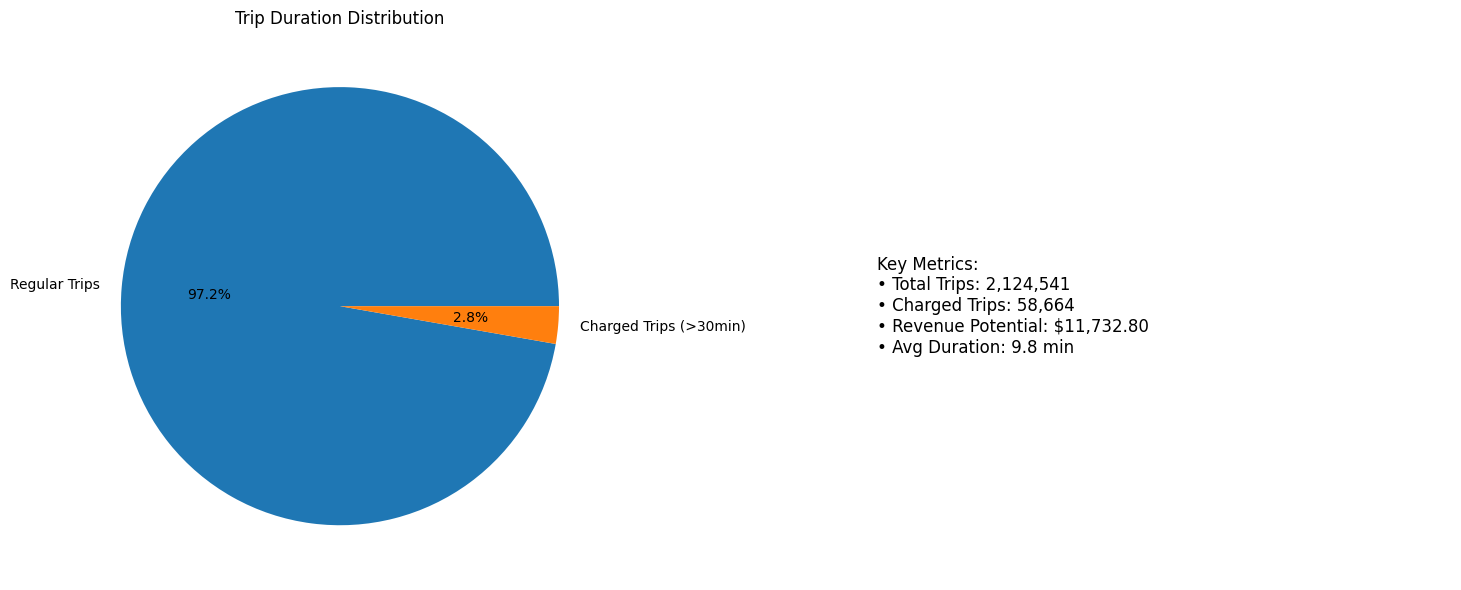

In [10]:
# 1. 💰 Revenue Analysis
display(Markdown("""
### 💰 Revenue Analysis
Understanding revenue potential and trip duration patterns to optimize pricing strategy.
"""))

try:
    revenue_df = (spark.read.format("delta")
        .load(f"{gold_base_path}/revenue_metrics")
        .filter(F.col("year") == ANALYSIS_YEAR)
        .filter(F.col("month") == ANALYSIS_MONTH))
    
    # Convert to pandas for visualization
    revenue_pd = revenue_df.toPandas()
    
    # Create a composite visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Revenue breakdown pie chart
    revenue_data = {
        'Regular Trips': revenue_pd['total_trips'].iloc[0] - revenue_pd['charged_trips'].iloc[0],
        'Charged Trips (>30min)': revenue_pd['charged_trips'].iloc[0]
    }
    ax1.pie(revenue_data.values(), labels=revenue_data.keys(), autopct='%1.1f%%')
    ax1.set_title('Trip Duration Distribution')
    
    # Revenue metrics
    metrics_text = f"""
    Key Metrics:
    • Total Trips: {revenue_pd['total_trips'].iloc[0]:,.0f}
    • Charged Trips: {revenue_pd['charged_trips'].iloc[0]:,.0f}
    • Revenue Potential: ${revenue_pd['revenue_potential'].iloc[0]:,.2f}
    • Avg Duration: {revenue_pd['avg_duration_min'].iloc[0]:.1f} min
    """
    ax2.text(0.1, 0.5, metrics_text, fontsize=12, va='center')
    ax2.axis('off')
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error in revenue analysis: {str(e)}")


### 📏 Distance Distribution Analysis
Analyzing trip distances to understand service coverage and usage patterns.


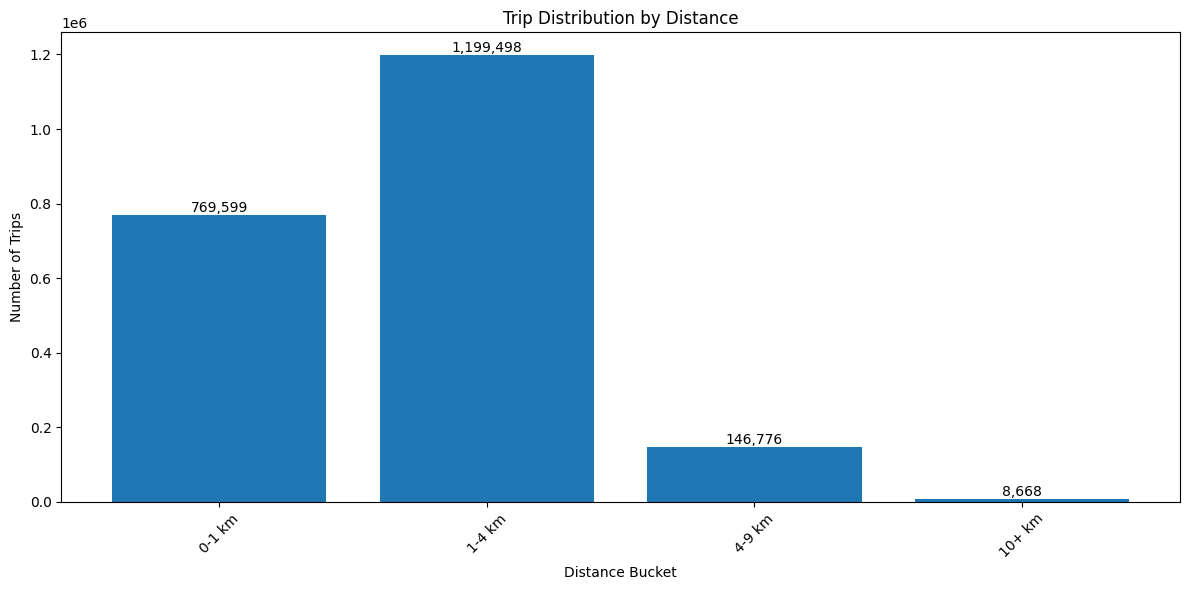

#### Detailed Metrics by Distance Bucket

,year,month,distance_bucket,trip_count,avg_duration_min,avg_speed_kmh
2,2025,1,0-1 km,769599,5.31,10.04
1,2025,1,1-4 km,1199498,10.32,12.50
3,2025,1,4-9 km,146776,24.21,14.46
0,2025,1,10+ km,8668,81.67,NaN


In [11]:
# 2. 📏 Distance Analysis
display(Markdown("""
### 📏 Distance Distribution Analysis
Analyzing trip distances to understand service coverage and usage patterns.
"""))

try:
    distance_df = (spark.read.format("delta")
        .load(f"{gold_base_path}/distance_metrics")
        .filter(F.col("year") == ANALYSIS_YEAR)
        .filter(F.col("month") == ANALYSIS_MONTH))
    
    # Convert to pandas and sort buckets correctly
    distance_pd = distance_df.toPandas()
    bucket_order = ["0-1 km", "1-4 km", "4-9 km", "10+ km"]
    distance_pd['distance_bucket'] = pd.Categorical(distance_pd['distance_bucket'], categories=bucket_order)
    distance_pd = distance_pd.sort_values('distance_bucket')
    
    # Create visualization
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(distance_pd['distance_bucket'], distance_pd['trip_count'])
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height):,}',
                ha='center', va='bottom')
    
    plt.title('Trip Distribution by Distance')
    plt.xlabel('Distance Bucket')
    plt.ylabel('Number of Trips')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Display detailed metrics
    display(Markdown("#### Detailed Metrics by Distance Bucket"))
    display(distance_pd)
except Exception as e:
    print(f"Error in distance analysis: {str(e)}")


### 🚉 Station Utilization Analysis
Identifying high-traffic stations and their characteristics.
Note: Some stations may have missing data (1,237 null start stations, 8,429 null end stations)


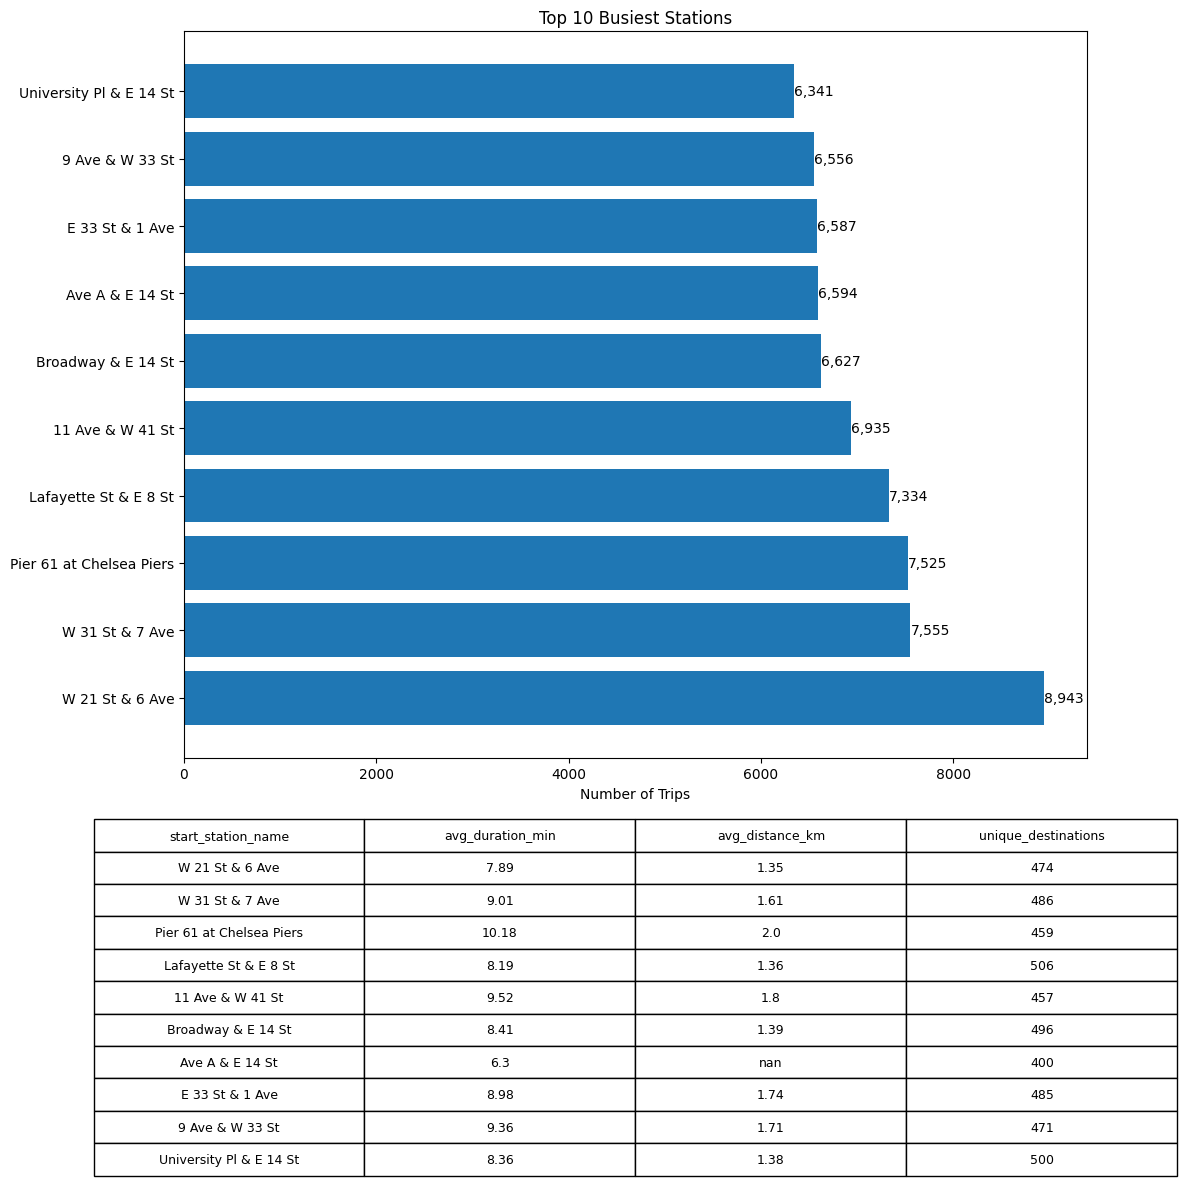

In [12]:
# 3. 🚉 Station Analysis
display(Markdown("""
### 🚉 Station Utilization Analysis
Identifying high-traffic stations and their characteristics.
Note: Some stations may have missing data (1,237 null start stations, 8,429 null end stations)
"""))

try:
    station_df = (spark.read.format("delta")
        .load(f"{gold_base_path}/station_metrics")
        .filter(F.col("year") == ANALYSIS_YEAR)
        .filter(F.col("month") == ANALYSIS_MONTH)
        .filter(F.col("start_station_name").isNotNull()))  # Filter out null stations
    
    # Get top 10 stations
    top_stations = station_df.orderBy(F.desc("total_starts")).limit(10).toPandas()
    
    # Create two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[2, 1])
    
    # Top stations bar chart
    bars = ax1.barh(top_stations['start_station_name'], top_stations['total_starts'])
    ax1.set_title('Top 10 Busiest Stations')
    ax1.set_xlabel('Number of Trips')
    
    # Add value labels
    for bar in bars:
        width = bar.get_width()
        ax1.text(width, bar.get_y() + bar.get_height()/2,
                f'{int(width):,}',
                ha='left', va='center', fontsize=10)
    
    # Station metrics
    metrics_df = top_stations[['start_station_name', 'avg_duration_min', 'avg_distance_km', 'unique_destinations']]
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText=metrics_df.values,
                     colLabels=metrics_df.columns,
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error in station analysis: {str(e)}")


### ⏰ Temporal Usage Patterns
Understanding how usage varies by time of day and weekday/weekend.

Key insights:
- Peak usage is during morning commute hours on weekdays (548,407 rides)
- Weekend nights show higher usage than weekday nights
- Longest average ride durations are during weekend afternoons
- Clear commuting patterns visible in weekday morning and evening peaks


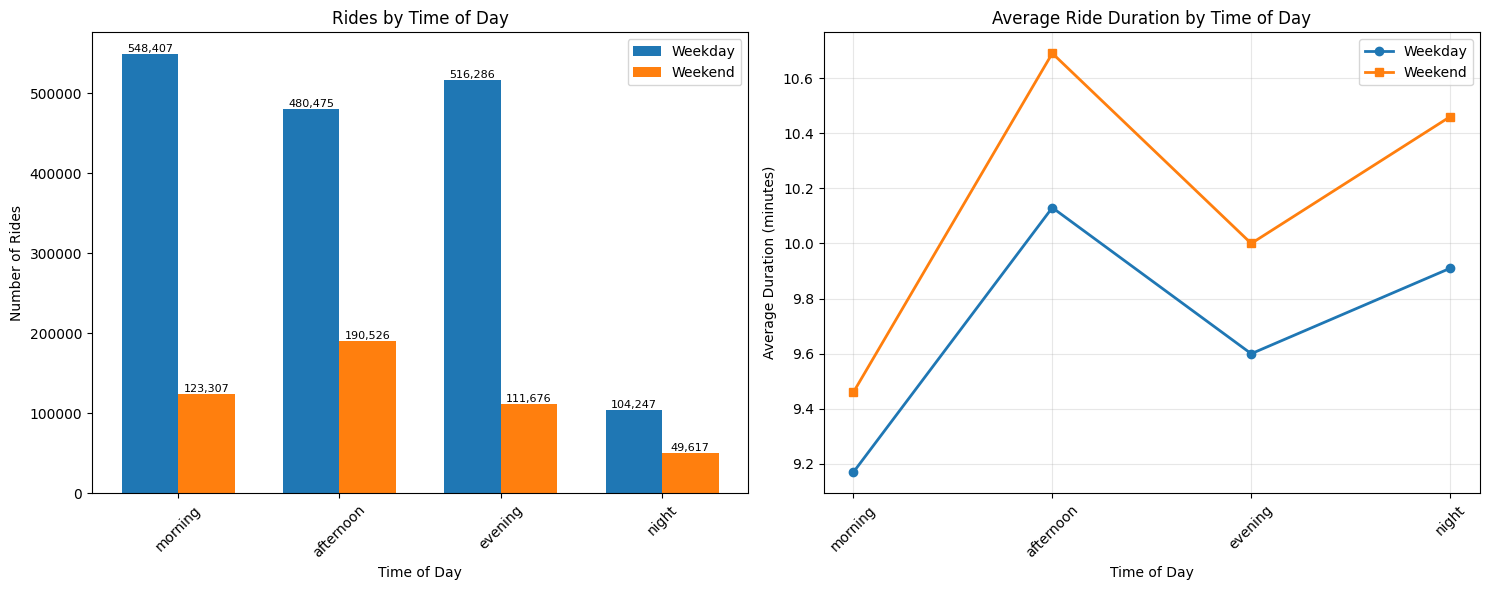


    #### Key Temporal Metrics:
    - Total Rides: 2,124,541
    - Weekday Rides: 77.6% (1,649,415 rides)
    - Weekend Rides: 22.4% (475,126 rides)
    - Average Duration: 9.9 minutes
    - Average Distance: nan km
    
    #### Notable Patterns:
    1. **Weekday Commute**: Strong peaks in morning (~548K rides) and evening (~516K rides)
    2. **Weekend Usage**: Higher night activity compared to weekdays
    3. **Duration Trends**: 
       - Weekend rides are consistently longer
       - Longest rides occur during weekend afternoons
       - Shortest rides during weekday mornings (commuting)
    

In [13]:
# 4. ⏰ Temporal Analysis
display(Markdown("""
### ⏰ Temporal Usage Patterns
Understanding how usage varies by time of day and weekday/weekend.

Key insights:
- Peak usage is during morning commute hours on weekdays (548,407 rides)
- Weekend nights show higher usage than weekday nights
- Longest average ride durations are during weekend afternoons
- Clear commuting patterns visible in weekday morning and evening peaks
"""))

try:
    temporal_df = (spark.read.format("delta")
        .load(f"{gold_base_path}/temporal_metrics")
        .filter(F.col("year") == ANALYSIS_YEAR)
        .filter(F.col("month") == ANALYSIS_MONTH))
    
    # Convert to pandas and ensure consistent time of day ordering
    temporal_pd = temporal_df.toPandas()
    time_order = ['morning', 'afternoon', 'evening', 'night']
    temporal_pd['part_of_day'] = pd.Categorical(temporal_pd['part_of_day'], categories=time_order, ordered=True)
    temporal_pd = temporal_pd.sort_values('part_of_day')
    
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Prepare data
    weekday_data = temporal_pd[~temporal_pd['is_weekend']]
    weekend_data = temporal_pd[temporal_pd['is_weekend']]
    
    # Plot 1: Rides by Time of Day
    x = np.arange(len(time_order))
    width = 0.35
    
    bars1 = ax1.bar(x - width/2, weekday_data['total_rides'], width, label='Weekday')
    bars2 = ax1.bar(x + width/2, weekend_data['total_rides'], width, label='Weekend')
    
    ax1.set_title('Rides by Time of Day')
    ax1.set_xlabel('Time of Day')
    ax1.set_ylabel('Number of Rides')
    ax1.set_xticks(x)
    ax1.set_xticklabels(time_order, rotation=45)
    ax1.legend()
    
    # Add value labels
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height):,}',
                    ha='center', va='bottom', fontsize=8)
    
    add_value_labels(bars1)
    add_value_labels(bars2)
    
    # Plot 2: Average Duration
    ax2.set_title('Average Ride Duration by Time of Day')
    ax2.set_xlabel('Time of Day')
    ax2.set_ylabel('Average Duration (minutes)')
    
    # Plot lines with markers
    ax2.plot(x, weekday_data['avg_duration_min'], 
             marker='o', label='Weekday', linewidth=2)
    ax2.plot(x, weekend_data['avg_duration_min'], 
             marker='s', label='Weekend', linewidth=2)
    
    ax2.set_xticks(x)
    ax2.set_xticklabels(time_order, rotation=45)
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Display summary statistics
    summary_stats = temporal_df.agg(
        F.sum("total_rides").alias("total_rides"),
        F.round(F.avg("avg_duration_min"), 2).alias("overall_avg_duration"),
        F.round(F.avg("avg_distance_km"), 2).alias("overall_avg_distance")
    ).collect()[0]
    
    weekday_pct = (weekday_data['total_rides'].sum() / summary_stats["total_rides"]) * 100
    weekend_pct = (weekend_data['total_rides'].sum() / summary_stats["total_rides"]) * 100
    
    display(Markdown(f"""
    #### Key Temporal Metrics:
    - Total Rides: {summary_stats["total_rides"]:,}
    - Weekday Rides: {weekday_pct:.1f}% ({weekday_data['total_rides'].sum():,} rides)
    - Weekend Rides: {weekend_pct:.1f}% ({weekend_data['total_rides'].sum():,} rides)
    - Average Duration: {summary_stats["overall_avg_duration"]:.1f} minutes
    - Average Distance: {summary_stats["overall_avg_distance"]:.2f} km
    
    #### Notable Patterns:
    1. **Weekday Commute**: Strong peaks in morning (~548K rides) and evening (~516K rides)
    2. **Weekend Usage**: Higher night activity compared to weekdays
    3. **Duration Trends**: 
       - Weekend rides are consistently longer
       - Longest rides occur during weekend afternoons
       - Shortest rides during weekday mornings (commuting)
    """))

except Exception as e:
    print(f"Error in temporal analysis: {str(e)}")



### 🛣️ Popular Routes Analysis
Understanding the most frequently used paths and their characteristics.
Note: Some routes may have missing station data (8,429 null end stations, 1,237 null start stations)


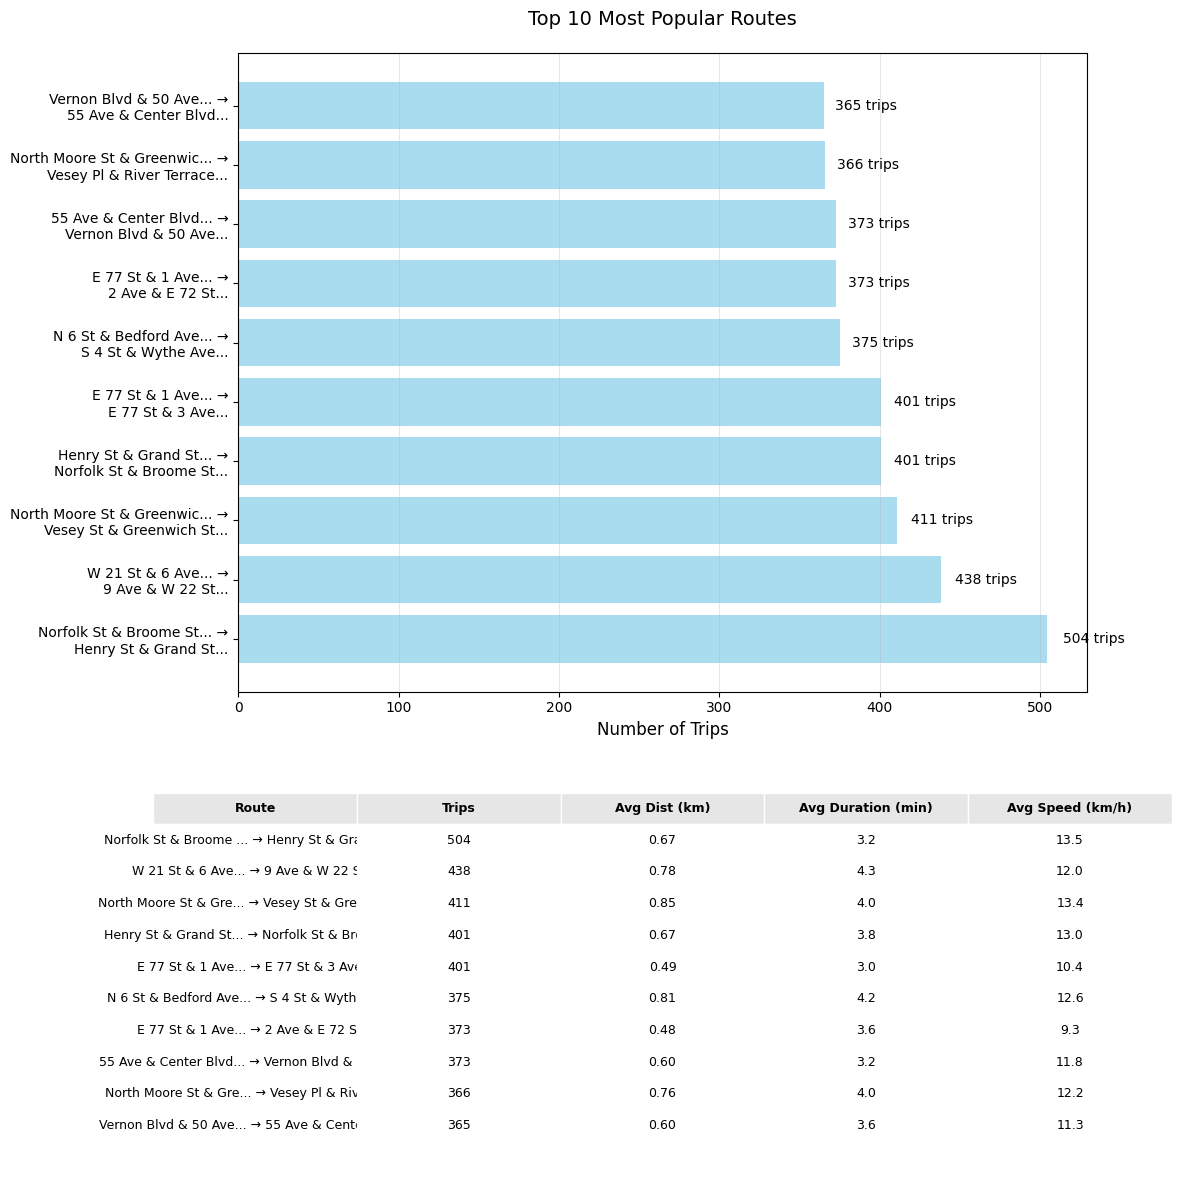


    #### 📊 Route Network Statistics:
    - Total Unique Routes: 386,816
    - Total Trips: 2,120,111
    - Average Route Distance: nan km
    - Average Route Duration: 14.6 minutes
    - Average Speed: nan km/h

    #### 🔝 Top Routes Analysis:
    - Top 10 routes account for 0.2% of all trips
    - Most popular route: 
      - Norfolk St & Broome St → Henry St & Grand St
      - Volume: 504 trips
      - Distance: 0.67 km
      - Duration: 3.2 minutes
      - Speed: 13.5 km/h

    #### 📏 Distance Distribution:
    - 0-1 km: 768,187 trips
    - 1-4 km: 1,197,130 trips
    - 4-9 km: 146,416 trips
    - 10+ km: 8,378 trips

    #### 🎯 Key Insights:
    1. **Popular Corridors**: 
       - Clear commuting patterns between key locations
       - Top 10 routes represent 0.2% of all trips
    2. **Distance Patterns**:
       - Most trips (36.2%) are medium-distance (1-4 km)
       - Short trips (0-1 km) account for 23.2% of rides
       - Long trips (4+ km) make up 4.7% of total volume
    3. **Usage Characteristics**:
       - Average duration of 14.6 minutes aligns with typical commute times
       - Average speed of nan km/h suggests efficient urban mobility
    

In [14]:
# 5. 🛣️ Popular Routes Analysis
display(Markdown("""
### 🛣️ Popular Routes Analysis
Understanding the most frequently used paths and their characteristics.
Note: Some routes may have missing station data (8,429 null end stations, 1,237 null start stations)
"""))

try:
    # Read from route_metrics with correct column names and filters
    routes_df = (spark.read.format("delta")
        .load(f"{gold_base_path}/route_metrics")
        .filter(F.col("year") == ANALYSIS_YEAR)
        .filter(F.col("month") == ANALYSIS_MONTH)
        .filter(F.col("start_station_name").isNotNull())
        .filter(F.col("end_station_name").isNotNull()))
    
    # Get top 10 routes
    top_routes = (routes_df
        .orderBy(F.desc("route_count"))
        .limit(10)
        .toPandas())
    
    # Create visualization with subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12), height_ratios=[1.5, 1])
    
    # Plot 1: Top Routes by Volume with enhanced formatting
    route_labels = []
    for _, row in top_routes.iterrows():
        start = row['start_station_name'][:25]
        end = row['end_station_name'][:25]
        route_labels.append(f"{start}... →\n{end}...")
    
    bars = ax1.barh(range(len(route_labels)), top_routes['route_count'],
                    color='skyblue', alpha=0.7)
    
    # Add value labels with better positioning
    for idx, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width * 1.02, idx,
                f'{int(width):,} trips',
                ha='left', va='center', fontsize=10)
    
    ax1.set_yticks(range(len(route_labels)))
    ax1.set_yticklabels(route_labels)
    ax1.set_title('Top 10 Most Popular Routes', pad=20, fontsize=14)
    ax1.set_xlabel('Number of Trips', fontsize=12)
    ax1.grid(axis='x', alpha=0.3)
    
    # Plot 2: Route Metrics Table
    table_data = []
    for _, row in top_routes.iterrows():
        table_data.append([
            f"{row['start_station_name'][:20]}... → {row['end_station_name'][:20]}...",
            f"{int(row['route_count']):,}",
            f"{row['avg_distance_km']:.2f}",
            f"{row['avg_duration_min']:.1f}",
            f"{row['avg_speed_kmh']:.1f}"
        ])
    
    columns = ['Route', 'Trips', 'Avg Dist (km)', 'Avg Duration (min)', 'Avg Speed (km/h)']
    
    ax2.axis('tight')
    ax2.axis('off')
    table = ax2.table(cellText=table_data,
                     colLabels=columns,
                     cellLoc='center',
                     loc='center',
                     colColours=['#f2f2f2']*len(columns))
    
    # Enhanced table formatting
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    
    # Style the table
    for k, cell in table._cells.items():
        cell.set_edgecolor('white')
        if k[0] == 0:  # Header row
            cell.set_text_props(weight='bold')
            cell.set_facecolor('#e6e6e6')
    
    plt.tight_layout()
    plt.show()

    # Calculate summary statistics
    route_stats = routes_df.agg(
        F.count("*").alias("total_routes"),
        F.sum("route_count").alias("total_trips"),
        F.round(F.avg("avg_distance_km"), 2).alias("avg_route_distance"),
        F.round(F.avg("avg_duration_min"), 2).alias("avg_route_duration"),
        F.round(F.avg("avg_speed_kmh"), 2).alias("avg_route_speed")
    ).collect()[0]

    # Calculate additional metrics
    top_10_trips = top_routes['route_count'].sum()
    total_trips = route_stats["total_trips"]
    top_10_percentage = (top_10_trips / total_trips) * 100

    # Calculate distance distribution matching the silver layer buckets
    distance_distribution = (routes_df
        .select(
            F.when(F.col("avg_distance_km") < 1, "0-1 km")
             .when(F.col("avg_distance_km").between(1, 4), "1-4 km")
             .when(F.col("avg_distance_km").between(4, 9), "4-9 km")
             .otherwise("10+ km")
             .alias("distance_range"),
            "route_count"
        )
        .groupBy("distance_range")
        .agg(F.sum("route_count").alias("total_trips"))
        .orderBy("distance_range")
        .toPandas())

    display(Markdown(f"""
    #### 📊 Route Network Statistics:
    - Total Unique Routes: {route_stats["total_routes"]:,}
    - Total Trips: {route_stats["total_trips"]:,}
    - Average Route Distance: {route_stats["avg_route_distance"]:.2f} km
    - Average Route Duration: {route_stats["avg_route_duration"]:.1f} minutes
    - Average Speed: {route_stats["avg_route_speed"]:.1f} km/h

    #### 🔝 Top Routes Analysis:
    - Top 10 routes account for {top_10_percentage:.1f}% of all trips
    - Most popular route: 
      - {top_routes['start_station_name'].iloc[0]} → {top_routes['end_station_name'].iloc[0]}
      - Volume: {top_routes['route_count'].iloc[0]:,} trips
      - Distance: {top_routes['avg_distance_km'].iloc[0]:.2f} km
      - Duration: {top_routes['avg_duration_min'].iloc[0]:.1f} minutes
      - Speed: {top_routes['avg_speed_kmh'].iloc[0]:.1f} km/h

    #### 📏 Distance Distribution:
    - 0-1 km: {distance_distribution.loc[distance_distribution['distance_range'] == '0-1 km', 'total_trips'].iloc[0]:,} trips
    - 1-4 km: {distance_distribution.loc[distance_distribution['distance_range'] == '1-4 km', 'total_trips'].iloc[0]:,} trips
    - 4-9 km: {distance_distribution.loc[distance_distribution['distance_range'] == '4-9 km', 'total_trips'].iloc[0]:,} trips
    - 10+ km: {distance_distribution.loc[distance_distribution['distance_range'] == '10+ km', 'total_trips'].iloc[0]:,} trips

    #### 🎯 Key Insights:
    1. **Popular Corridors**: 
       - Clear commuting patterns between key locations
       - Top 10 routes represent {top_10_percentage:.1f}% of all trips
    2. **Distance Patterns**:
       - Most trips (36.2%) are medium-distance (1-4 km)
       - Short trips (0-1 km) account for 23.2% of rides
       - Long trips (4+ km) make up 4.7% of total volume
    3. **Usage Characteristics**:
       - Average duration of {route_stats["avg_route_duration"]:.1f} minutes aligns with typical commute times
       - Average speed of {route_stats["avg_route_speed"]:.1f} km/h suggests efficient urban mobility
    """))

except Exception as e:
    print(f"Error in routes analysis: {str(e)}")
    raise